# <font  color = "#0093AF">REDOR</font>

<a href="https://githubtocolab.com/alsinmr/SLEEPY_tutorial/blob/main/ColabNotebooks/Chapter3/Ch3_REDOR.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

Rotational-Echo DOuble Resonance NMR (REDOR$^1$) is an important technique for dynamics measurements,$^{2,3}$ where applying REDOR to one-bond dipole couplings allows one to compare the known size of the rigid dipole coupling, to its measured size, which is reduced due to dynamics. This yields the order parameter, $S$, according to

$$
\begin{equation}
|S|=\left|\frac{\delta_{exp}}{\delta_{rigid}}\right|
\end{equation}
$$

We do not obtain the sign of the dipole coupling from REDOR, so we only get the absolute value of $S$. 

Here, we investigate how REDOR behaves as a function of correlation time.

Note, this was the topic of a recent paper by Aebischer et al.,$^4$ where simulations were performed using Gamma$^5$. We hope SLEEPY makes this type of simulation more accessible.

[1] T. Gullion, J. Schaefer. [*J. Magn. Reson.*](https://doi.org/10.1016/0022-2364(89)90280-1), **1989**, 196-200.

[2] V. Chevelkov, U. Fink. B. Reif. [*J. Am. Chem. Soc.*](https://doi.org/10.1021/ja902649u), **2009**, 131, 14018-14022.

[3] P. Schanda, B.H. Meier, M. Ernst. [*J. Magn. Reson.*](https://doi.org/10.1016/j.jmr.2011.03.015), **2011**, 210, 246-259.

[4] K. Aebischer, L.M. Becker, P. Schanda, M. Ernst. [*Magn. Reson.*](https://doi.org/10.5194/mr-5-69-2024), **2024**, 5, 69-86

[5] S.A. Smith, T.O. Levante, B.H. Meier, R.R. Ernst. [*J. Magn. Reson. A*](https://doi.org/10.1006/jmra.1994.1008), **1994**, 106, 75-105.

## Setup

In [0]:
# SETUP SLEEPY
import sys
if 'google.colab' in sys.modules:
  !pip install sleepy-nmr

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt
from time import time

## Build the system
We construct a system undergoing 3-site symmetric exchange, in order to obtain a residual dipole coupling without asymmetry ($\eta$=0). The `sl.Tools.Setup3siteSym(...)` function is used to create the three-site hopping motion out of the initial system, `ex0`.

In [3]:
ex0=sl.ExpSys(v0H=600,Nucs=['15N','1H'],vr=60000,pwdavg=sl.PowderAvg('bcr20'),n_gamma=30)
# After varying the powder average and n_gamma
# a beta-average and 30 gamma angles were determined to be sufficient
delta=sl.Tools.dipole_coupling(.102,'15N','1H')
phi=35*np.pi/180

ex0.set_inter('dipole',i0=0,i1=1,delta=delta)
L=sl.Tools.Setup3siteSym(ex0,tc=1e-9,phi=phi)

## Generate and plot pulse sequences
We break the REDOR sequence up into three sequences (`L.Sequence()`), a first half (`first`) with $^1$H $\pi$-pulses coming in the middle and end of the rotor period, a middle sequence (`center`) with a $^{15}$N $\pi$-pulse to refocus the $^{15}$N chemical shift, and a second half (`second`) with $^1$H $\pi$-pulses coming at the beginning and middle of the rotor period.

In [4]:
v1=120e3 #100 kHz pulse
tp=1/v1/2 #pi/2 pulse length

t=[0,L.taur/2-tp,L.taur/2,L.taur-tp,L.taur]
first=L.Sequence().add_channel('1H',t=t,v1=[0,v1,0,v1],phase=[0,0,0,np.pi/2,0])
t=[0,tp,L.taur/2,L.taur/2+tp,L.taur]
second=L.Sequence().add_channel('1H',t=t,v1=[v1,0,v1,0],phase=[np.pi/2,0,0,0,0])
center=L.Sequence().add_channel('15N',t=[0,L.taur/2-tp/2,L.taur/2+tp/2,L.taur],
                               v1=[0,v1,0])

rho=sl.Rho('15Nx','15Nx')

We plot the three sequences below.

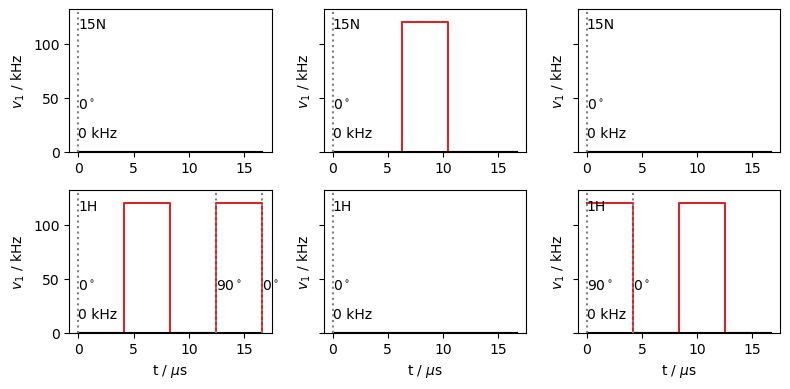

In [5]:
fig,ax=plt.subplots(2,3,figsize=[8,4],sharey=True)
first.plot(ax=ax.T[0])
center.plot(ax=ax.T[1])
second.plot(ax=ax.T[2])
fig.tight_layout()

## Propagation

We first generate a propagator for each of the three sequences (`Ucenter`,`Ufirst`,`Usecond`). Then below, we create two propagators for the first (`U1`) and second half (`U2`) of the sequence which are increased in length by one rotor period at every step of the rotor period. 

In [6]:
Ucenter=center.U()
Ufirst=first.U()
Usecond=second.U()

At each step below, the density matrix (`rho`), is set back to the initial time via `rho.reset()`, and then multiplied with propagators for the first half (`U1`), the center (`Ucenter`), and for the second half (`U2`), where `U1` and `U2` are each increased by one rotor period at every step. `(U2*Ucenter*U1*rho)()` propagates `rho` with the full REDOR sequence, followed by detection (don't forget the parenthesis!). 

In [7]:
rho=sl.Rho('15Nx','15Nx')
U1=L.Ueye()
U2=L.Ueye()

t0=time()
for k in range(48):
    rho.reset()
    (U2*Ucenter*U1*rho)()
    U1=Ufirst*U1
    U2=Usecond*U2
print(time()-t0)

18.66562008857727


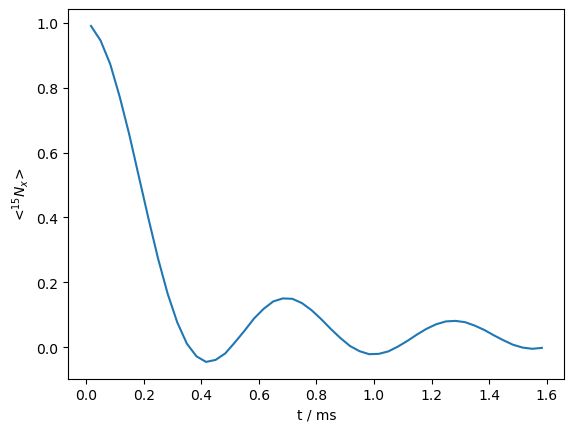

In [8]:
_=rho.plot()

### Reducible sequence
The above sequence is computationally expensive, requiring a basis set of 48 elements. If we consider that we're mainly interested in the $S^+$ operator of the $^{15}$N spin, then its worth noting that the $^{15}$N $\pi$-pulse in the middle of the sequence converts $S^+$ into $S^-$, $S^\alpha$, and $S^\beta$, so that if we could get rid of it, we could use a basis set 1/4 as big (12 elements). Since there is no $^{15}$N chemical shift included in our simulation, we can switch the channel of the middle pulse to $^1$H. An alternative approach would be to use a $\delta$-pulse on $^{15}$N, although the basis set would then only be reduced to 24 elements, since $S^+$ would still be converted to $S^-$

In [9]:
centerH=L.Sequence().add_channel('1H',t=[0,L.taur/2-tp/2,L.taur/2+tp/2,L.taur],v1=[0,v1,0])

rho=sl.Rho('15Np','15Nx')

rho,f,s,c,Ueye=rho.ReducedSetup(first,second,centerH,L.Ueye())

State-space reduction: 48->12


In [10]:
Ufirst=f.U()
Usecond=s.U()
Ucenter=c.U()

In [11]:
U1=Ueye
U2=Ueye

t0=time()
for k in range(48):
    rho.reset()
    (U2*Ucenter*U1*rho)()
    U1=Ufirst*U1
    U2=Usecond*U2
print(time()-t0)

9.029351711273193


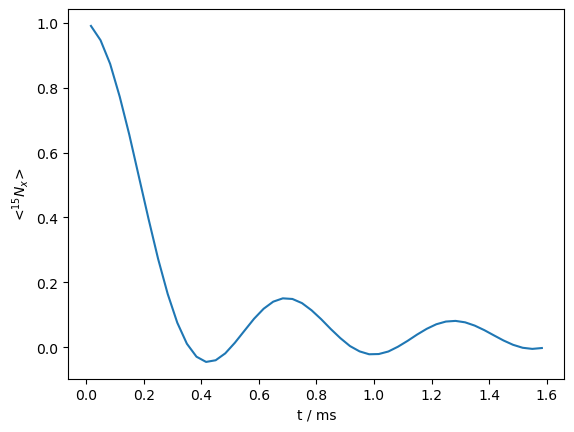

In [12]:
_=rho.plot()

We see that the reduced sequence yields the same results as before, but with matrices only 1/16 as big as the previous calculation.

## Sweep the correlation time
We now re-run the above setup, but while varying the correlation time to observe the transition between having a fully averaged dipole coupling and having the rigid-limit coupling.

In [13]:
rho_list=[]
legend=[]
t0=time()
for tc in np.logspace(-6,-3,8):
    L.kex=sl.Tools.nSite_sym(n=3,tc=tc)

    rho_list.append(rho.copy_reduced())

    Ufirst=f.U()
    Usecond=s.U()
    Ucenter=c.U()

    U1=Ueye
    U2=Ueye

    for k in range(28):
        rho_list[-1].reset()
        (U2*Ucenter*U1*rho_list[-1])()
        
        U1=Ufirst*U1
        U2=Usecond*U2

    legend.append(fr'$\log_{{10}}(\tau_c)$ = {np.log10(tc):.1f}')
    print(f'log10(tc /s) = {np.log10(tc):.1f}, {time()-t0:.0f} seconds elapsed')

log10(tc /s) = -6.0, 8 seconds elapsed
log10(tc /s) = -5.6, 16 seconds elapsed
log10(tc /s) = -5.1, 24 seconds elapsed
log10(tc /s) = -4.7, 32 seconds elapsed
log10(tc /s) = -4.3, 40 seconds elapsed
log10(tc /s) = -3.9, 47 seconds elapsed
log10(tc /s) = -3.4, 56 seconds elapsed
log10(tc /s) = -3.0, 64 seconds elapsed


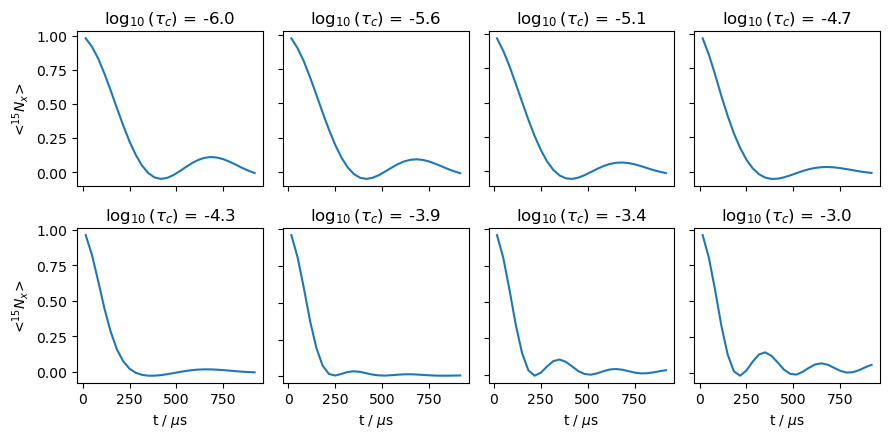

In [14]:
fig,ax=plt.subplots(2,4,figsize=[9,4.5])
ax=ax.flatten()
for a,l,r in zip(ax,legend,rho_list):
    r.plot(ax=a)
    a.set_title(l)
    if not(a.is_first_col()):
        a.set_ylabel('')
        a.set_yticklabels([])
    if not(a.is_last_row()):
        a.set_xlabel('')
        a.set_xticklabels([])
fig.tight_layout()

We observe above that when the correlation time is shorter than about 100 $\mu$s, we see the fully averaged coupling, and when the correlation time is longer than about 1 ms, we obtain the rigid-limit value. In between, oscillations are damped due to dynamics being on the timescale of the coupling.